# A simple regulator problem

$$
\left \lbrace
\begin{array}{l}
Min\ \frac{1}{2}\int_0^5 (x_1^2(t) + x_2^2(t)) dt\\
\dot x_1 = x_2\\ 
\dot x_2 = u\\
u(\cdot) \in [-1,1]\\
x(0)=(0,1)\\
\end{array}
\right .
$$

[Thumbnail](regulator.png)

### Direct method

In [1]:
!pygmentize problem.cpp

// +++DRAFT+++ This class implements the OCP functions
// It derives from the generic class bocop3OCPBase
// OCP functions are defined with templates since they will be called
// from both the NLP solver (double arguments) and AD tool (ad_double arguments)
//#pragma once

#include <OCP.h>

// ///////////////////////////////////////////////////////////////////


template <typename Variable>
inline void OCP::finalCost(double initial_time, double final_time, const Variable *initial_state, const Variable *final_state, const Variable *parameters, const double *constants, Variable &final_cost)
{
    final_cost = final_state[2];
}

template <typename Variable>
inline void OCP::dynamics(double time, const Variable *state, const Variable *control, const Variable *parameters, const double *constants, Variable *state_dynamics)
{
    Variable x1 = state[0];
    Variable x2 = state[1];
    Variable u = control[0];
    state_dynamics[0] = x2;
    state_dynamics[1] = u;
    state_dynamics[2] = 0.5*(x

In [1]:
%matplotlib inline
import bocop

problem_path = "." # using local problem definition
bocop.build(problem_path, cmake_options = '-DCMAKE_CXX_COMPILER=g++')

[EXEC] > ['cmake -DCMAKE_BUILD_TYPE=Debug -DPROBLEM_DIR=/home/martinon/bocop/gallery/examples/regulator -DCPP_FILE=problem.cpp  -DCMAKE_CXX_COMPILER=g++  /home/martinon/bocop/bocop3/bocop']
>	-- The C compiler identification is GNU 9.3.0
>	-- The CXX compiler identification is GNU 9.3.0
>	-- Detecting C compiler ABI info
>	-- Detecting C compiler ABI info - done
>	-- Check for working C compiler: /home/martinon/miniconda3/envs/bocop-dev/bin/x86_64-conda-linux-gnu-cc - skipped
>	-- Detecting C compile features
>	-- Detecting C compile features - done
>	-- Detecting CXX compiler ABI info
>	-- Detecting CXX compiler ABI info - done
>	-- Check for working CXX compiler: /usr/bin/g++ - skipped
>	-- Detecting CXX compile features
>	-- Detecting CXX compile features - done
>	-- Problem path: /home/martinon/bocop/gallery/examples/regulator
>	-- Using CPPAD found at /home/martinon/miniconda3/envs/bocop-dev/include/cppad/..
>	-- Using IPOPT found at /home/martinon/miniconda3/envs/bocop-dev/lib/li

0

In [2]:
bocop.run(problem_path)

interactive(children=(IntSlider(value=18, continuous_update=False, description='iteration', max=18), Output())…

Done


Loading solution:  ./problem.sol


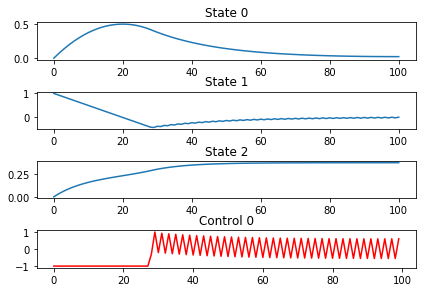

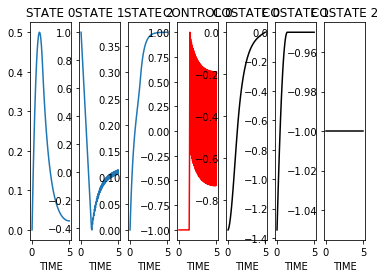

In [3]:
import matplotlib.pyplot as plt
solution = bocop.readSolution(problem_path + "/problem.sol")
solution.plot(graph=2)
#bocop.low_diagnose(solution)    

In [4]:
print("Bocop returns status {} with objective {:2.4g} and constraint violation {:2.4g}".format(solution.status,solution.objective,solution.constraints))
p0 = solution.costate[0:solution.dim_state,0]
print("Costate at first time stage (t0+h/2): ",p0)
print("Multipliers for initial conditions: ",solution.boundarycond_multipliers[0:solution.dim_state])

Bocop returns status 0 with objective 0.3767 and constraint violation 1.405e-14
Costate at first time stage (t0+h/2):  [-0.94057305 -1.34559103 -1.        ]
Multipliers for initial conditions:  [-0.9417918  -1.44140015 -1.        ]


### Indirect method

In [9]:
import time
from nutopy import nle
from nutopy import tools
from nutopy import ocp
import numpy as np
import scipy.interpolate as interp

In [10]:
t0 = 0.
tf = 5.
x0 = np.array([0, 1])
lbda = 0. #unused continuation

In [11]:
# running cost
def df0fun(t, x, dx, u, du, lbda):
    df0 = x[0]*dx[0] + x[1]*dx[1]
    return df0

def d2f0fun(t, x, dx, d2x, u, du, d2u, lbda):
    d2f0 = dx[0]*d2x[0] + dx[1]*d2x[1]
    return d2f0

@tools.tensorize(df0fun, d2f0fun, tvars=(2, 3))
def f0fun(t, x, u, lbda):
    f0 = 0.5 * (x[0]**2 + x[1]**2)
    return f0

# dynamics
def dffun(t, x, dx, u, du, lbda):
    df = np.zeros(2)
    df[0] = dx[1]
    df[1] = du
    return df

def d2ffun(t, x, dx, d2x, u, du, d2u, lbda):
    d2f = np.zeros(2)
    return d2f

@tools.tensorize(dffun, d2ffun, tvars=(2, 3))
def ffun(t, x, u, lbda):
    f = np.zeros(2)
    f[0] = x[1]
    f[1] = u
    return f

o = ocp.OCP(f0fun, ffun)

In [12]:
# switching function
def dpsifun(t, x, dx, p, dp):
    return dp[1]
    
def psifun(t, x, p):
    return p[1]

# bang control
def dufun(t, x, dx, p, dp, lbda):
    return 0.

def d2ufun(t, x, dx, d2x, p, dp, d2p, lbda):
    return 0.

@tools.vectorize(vvars=(1, 2, 3))
@tools.tensorize(dufun, d2ufun, tvars=(2, 3))
def ufun(t, x, p, lbda):
    psi = psifun(t, x, p) # should not be 0 in this case
    if psi > 0.:
        u = -1.
    else:
        u = 1.
    return u

# singular control
def dufun2(t, x, dx, p, dp, lbda):
    return dx[0]

def d2ufun2(t, x, dx, d2x, p, dp, d2p, lbda):
    return d2x[0]

@tools.vectorize(vvars=(1, 2, 3))
@tools.tensorize(dufun2, d2ufun2, tvars=(2, 3))
def ufun2(t, x, p, lbda):
    return x[0]

# Hamiltonian and flow
beta = 1 # normal case
hfun = ocp.Hamiltonian.fromOCP(o, ufun, beta)
hfun2 = ocp.Hamiltonian.fromOCP(o, ufun2, beta)

f1 = ocp.Flow(hfun)
f2 = ocp.Flow(hfun2)

In [13]:
# shooting function
def dshoot(z, dz):
    
    # parse unknown z = (p0,t1,x1,p1)
    p0 = z[0:2]
    t1 = z[2]
    x1_in = z[3:5]
    p1_in = z[5:7]
    s = np.ones(7)
    dp0 = dz[0:2]
    dt1 = dz[2]
    dx1_in = dz[3:5]
    dp1_in = dz[5:7]
    ds = np.ones(7)
    
    # first bang arc
    (x1,dx1), (p1,dp1) = f1(t0, x0, (p0,dp0), (t1,dt1), lbda)
    s[3:5] = x1 - x1_in
    s[5:7] = p1 - p1_in
    ds[3:5] = dx1 - dx1_in
    ds[5:7] = dp1 - dp1_in
    
    # singular arc
    (xf,dxf), (pf,dpf) = f2((t1,dt1), (x1_in,dx1_in), (p1_in,dp1_in), tf, lbda)
    s[0:2] = pf
    psi, dpsi = psifun(t1, (x1_in, dx1_in), (p1_in, dp1_in))
    s[2] = psi
    ds[0:2] = dpf 
    ds[2] = dpsi

    return s, ds

@tools.tensorize(dshoot, full=True)
def shoot(z):
    
    # parse unknown z = (p0,t1,x1,p1)
    p0 = z[0:2]
    t1 = z[2]
    x1_in = z[3:5]
    p1_in = z[5:7]
    s = np.ones(7)
    
    # first bang arc
    x1, p1 = f1(t0, x0, p0, t1, lbda)
    s[3:5] = x1 - x1_in
    s[5:7] = p1 - p1_in
    
    # singular arc
    xf, pf = f2(t1, x1_in, p1_in, tf, lbda)
    s[0:2] = pf
    s[2] = psifun(t1, x1_in, p1_in)
        
    return s
    

In [14]:
# shooting function evaluation test  BEWARE COSTATE SIGN !    
z = np.array([0.94, 1.44, 1.4, 0.3, -0.4, 0.6, 0])
z_sol = z
print(shoot(z))

[ 5.50203086e+00 -3.65709109e+00  0.00000000e+00  1.20000000e-01
  4.44089210e-16 -1.82666667e-01  1.26666667e-03]


In [37]:
# find zero of shooting function
nleopt = nle.Options(SolverMethod='hybrj', Display='on', TolX=1e-4)
et = time.time(); sol = nle.solve(shoot, z, df=shoot, options=nleopt); z_sol = sol.x; et = time.time() - et
print('Elapsed time:', et, '\t z_sol =', z_sol, '\t shoot =', shoot(z_sol))


     Calls  |f(x)|                 |x|
 
         1  6.610176060395011e+00  2.350999787324533e+00
         2  9.697978485337630e-02  2.348350683151624e+00
         3  8.637773577866317e-03  2.340208894202660e+00
         4  4.251351185238525e-05  2.340869251201618e+00
         5  3.322277095076187e-07  2.340865884679580e+00

 Results of the nle solver method:

 xsol    =  [ 9.42173363e-01  1.44191020e+00  1.41376409e+00  4.14399639e-01
 -4.13764092e-01  4.13764102e-01  8.50114375e-23]
 f(xsol) =  [ 2.76152448e-07 -1.84701254e-07  8.50114375e-23 -6.20712981e-10
 -1.66533454e-16  2.52397603e-10  2.72320611e-10]
 nfev    =  5
 njev    =  1
 status  =  1
 success =  True 

 Successfully completed: relative error between two consecutive iterates is at most TolX.

Elapsed time: 0.6853206157684326 	 z_sol = [ 9.42173363e-01  1.44191020e+00  1.41376409e+00  4.14399639e-01
 -4.13764092e-01  4.13764102e-01  8.50114375e-23] 	 shoot = [ 2.76152448e-07 -1.84701254e-07  8.50114375e-23 -6.20712981e-

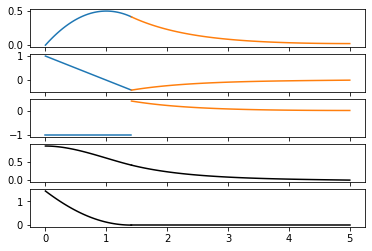

In [41]:
# plot solution
p0_sol = z_sol[0:2]
t1_sol = z_sol[2]
x1_sol = z_sol[3:5]
p1_sol = z_sol[5:7]

N = 100

tspan1 = list(np.linspace(t0, t1_sol, N+1))
x1, p1 = f1(t0, x0, p0_sol, tspan1, lbda)
u1 = ufun(tspan1, x1, p1, lbda)
x1 = np.array(x1); p1 = np.array(p1); u1 = np.array(u1)

tspan2 = list(np.linspace(t1_sol, tf, N+1))
x2, p2 = f2(t1_sol, x1_sol, p1_sol, tspan2, lbda)
u2 = ufun2(tspan2, x2, p2, lbda)
x2 = np.array(x2); p2 = np.array(p2); u2 = np.array(u2)
    
plt.subplot(5,1,1)
plt.plot(tspan1, x1[:, 0])
plt.plot(tspan2, x2[:, 0])

plt.subplot(5,1,2)
plt.plot(tspan1, x1[:, 1])
plt.plot(tspan2, x2[:, 1])

plt.subplot(5,1,3)
plt.plot(tspan1, u1)
plt.plot(tspan2, u2)

plt.subplot(5,1,4)
plt.plot(tspan1, p1[:, 0], 'k')
plt.plot(tspan2, p2[:, 0], 'k')

plt.subplot(5,1,5)
plt.plot(tspan1, p1[:, 1], 'k')
plt.plot(tspan2, p2[:, 1], 'k')